In [2]:
import itertools
from paddle.vision.datasets import Cifar10,MNIST
import matplotlib.pyplot as plt
import numpy as np

In [3]:
mnist_train = MNIST(
    mode= 'train',
    backend="cv2" 
)
cifar10_train = Cifar10(
    mode= 'train',
    backend="cv2"   # 指定要返回的图像类型：PIL.Image 或 numpy.ndarray。必须是 {'pil'，'cv2'} 中的值
)

A. Pixel-Block Partitioning and Block-based Random Permutation

In [4]:
img1,label1 = cifar10_train[0]
img1 = img1.astype("uint16")
l,m,c = img1.shape

In [29]:
img0,label0 = mnist_train[0]
img0 = img0.astype("uint16")
l,m = img0.shape

In [30]:
r,s = 4,4
t = (l*m) // (r*s)
# 检查整除性  
if l % r != 0 or m % s != 0:  
    raise ValueError("Image dimensions must be divisible by block dimensions.") 

In [31]:
t #28X28//2X2 = 196

49

In [32]:
blocks = (img0.reshape(l//r, r, m//s, s)  
            .transpose(0, 2, 1, 3)  
            .reshape(-1, r, s))  

# 获取块的数量  
t = blocks.shape[0]

In [33]:
from sklearn.utils import shuffle  # 使用scikit-learn的shuffle函数作为伪随机置换  

indices = np.arange(t)  
shuffled_indices = shuffle(indices)  
shuffled_blocks = blocks[shuffled_indices]  

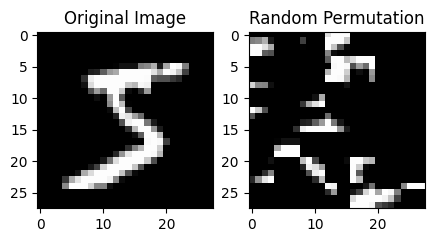

In [34]:
# 重新组合图像  
shuffled_image = shuffled_blocks.reshape(t//(m//s), m//s, r, s)  
shuffled_image = shuffled_image.transpose(0, 2, 1, 3).reshape(l, m)  
# 显示原始图像和重排的图像
fig, axs = plt.subplots(1, 2, figsize=(5, 5))  
axs[0].imshow(img0, cmap='gray')  
axs[0].set_title('Original Image')  
axs[1].imshow(shuffled_image, cmap='gray')  
axs[1].set_title('Random Permutation')  
plt.show()

# AES

In [35]:
from Crypto.Cipher import AES as aes
import random,os,math

In [49]:
class AES:

    def __init__(self, image_size=(32, 32), block_size=(4, 4), One_cipher=True, Shuffle=False):

        self.img_size = image_size

        self.block_size = block_size
        # 块数量
        self.block_num = int((image_size[0] / block_size[0]) * (image_size[1] / block_size[1]))

        print(image_size)
        print(block_size)

        print('block number = ' + str(self.block_num))

        block_bytes = block_size[0] * block_size[1] #块的字节大小 16

        self.scale = [1, 1] #放大情况

        self.shuffle = Shuffle

        self.one_cipher = One_cipher

        if block_bytes < 16:
            # scale it 放大 块字节小于AES加密字节16
            if self.block_size[0] < self.block_size[1]:

                less = 0

            else:

                less = 1

            if block_bytes == 2:

                self.scale[less] = 4

                self.scale[(less + 1) % 2] = 2

            elif block_bytes == 4:

                if self.block_size == (2, 2):

                    self.scale = [2, 2]

                else:

                    self.scale[less] = 4

            elif block_bytes == 8:

                self.scale[less] = 2

            self.block_size = (4, 4)

        self.update_params()  # due to updated parameters 更新参数

        if not One_cipher:

            self.ciphers = [aes.new(os.urandom(16), aes.MODE_ECB) for i in range(self.block_num)]

        else:

            self.ciphers = aes.new(os.urandom(16), aes.MODE_ECB)

    # 准备参数
    def update_params(self):

        image_size = self.img_size

        block_size = self.block_size # 更新为4x4
        
        # 填充

        if image_size[0] % block_size[0] != 0:

            p0 = block_size[0] - image_size[0] % block_size[0]

            self.p0_left = int(p0 / 2)

            self.p0_right = p0 - self.p0_left

        else:

            p0 = 0

            self.p0_left = 0

            self.p0_right = 0

        if image_size[1] % block_size[1] != 0:

            p1 = block_size[1] - image_size[1] % block_size[1]

            self.p1_left = int(p1 / 2)

            self.p1_right = p1 - self.p1_left

        else:

            p1 = 0

            self.p1_left = 0

            self.p1_right = 0

        if p0 == 0 and p1 == 0: #无需填充

            self.pad = False

        else:
            self.pad = True

        self.block_num = math.ceil(image_size[0] / block_size[0]) * math.ceil(image_size[1] / block_size[1])
        # 向上取整
        
    # 填充大小
    def padded_size(self):

        return (self.img_size[0] + self.p0_left + self.p0_right, self.img_size[1] + self.p1_left + self.p1_right)

    def padding(self, img):

        if len(self.img_size) == 3: #RGB图像

            assert ((img.shape[0], img.shape[1], img.shape[2]) == self.img_size)

        else:#Grey图像

            assert ((img.shape[0], img.shape[1]) == self.img_size)

        if not self.pad: #无需填充 直接copy返回
            return img.copy()

        if len(self.img_size) == 3:

            img1 = np.zeros((img.shape[0] + self.p0_left + self.p0_right, img.shape[1] + self.p1_left + self.p1_right,
                             img.shape[2]))

            for c in range(img.shape[2]):
                img1[:, :, c] = np.pad(img[:, :, c], ((self.p0_left, self.p0_right), (self.p1_left, self.p1_right)))

        else:

            img1 = np.zeros((img.shape[0] + self.p0_left + self.p0_right, img.shape[1] + self.p1_left + self.p1_right))

            img1[:, :] = np.pad(img[:, :], ((self.p0_left, self.p0_right), (self.p1_left, self.p1_right)))

        return img1 # 返回填充后的图像
    
    # 放大
    def scaleup(self, img): #按比例放大

        ''' img: w*h, each pixel duplicate to the corresponding 4x4 block
        每个像素复制到相应的4x4块
        '''

        assert (self.scale != [1, 1] and img.shape[0:2] == self.img_size)

        img1 = np.ones(img.shape)

        if len(img.shape) == 3:

            for c in range(img.shape[2]):

                for i in range(img.shape[0]):

                    for j in range(img.shape[1]):
                        img1[i * self.scale[0]:(i + 1) * self.scale[0], j * self.scale[1]:(j + 1) * self.scale[1], c] *= \
                        img[i, j, c]

        else:

            for i in range(img.shape[0]):

                for j in range(img.shape[1]):
                    img1[i * self.scale[0]:(i + 1) * self.scale[0], j * self.scale[1]:(j + 1) * self.scale[1]] *= img[
                        i, j]

        return img1.astype(np.byte)

    def M2vector(self, block):

        vec = block.reshape((1, block.shape[0] * block.shape[1]))

        return vec

    def vector2M(self, vector):

        M = vector.reshape((self.block_size[0], self.block_size[1]))

        return M
    
    # 分块
    def M2block(self, array):

        h, r = array.shape[0:2]

        blocks = []

        hight = [i * self.block_size[0] for i in range(int(h / self.block_size[0]))]

        width = [i * self.block_size[1] for i in range(int(r / self.block_size[1]))]

        for i in hight:

            for j in width:
                blocks.append(array[i:i + self.block_size[0], j:j + self.block_size[1]])

        return blocks
    
    # 随机合并块

    def block2M(self, block_list, seed=1):

        Row = []

        Column = []

        blocks = block_list

        if self.shuffle:
            random.Random(seed).shuffle(block_list)

        for i in range(self.block_num):

            if (i + 1) % (self.img_size[1] / self.block_size[1]) != 0:

                Row.append(blocks[i])


            else:

                Row.append(blocks[i])

                Column.append(np.hstack(Row))

                Row = []

        return np.vstack(Column)
    
    
    # 块加密
    def block_enc(self, block, cipher):

        block1 = self.M2vector(block)

        assert (block1.shape[1] % 16 == 0)

        for i in range(int(block1.shape[1] / 16)):
            bytes = cipher.encrypt(block1[:, i * 16:(i + 1) * 16].tobytes())

            block1[:, i * 16:(i + 1) * 16] = np.frombuffer(bytes, dtype=np.byte)

        return self.vector2M(block1)
    
    
    # 加密
    def Encode(self, img, noise = False, noise_level = 1):

        if (self.scale != [1, 1]):

            img1 = self.scaleup(img)

        else:

            img1 = img

        img2 = self.padding(img1).astype(np.byte)

        if len(img2.shape) == 3:

            for c in range(img2.shape[2]):  # channels

                blocks = self.M2block(img2[:, :, c])

                if not self.one_cipher:

                    blocks_e = [self.block_enc(b, e) for b, e in zip(blocks, self.ciphers)]

                else:

                    blocks_e = [self.block_enc(b, self.ciphers) for b in blocks]

                img2[:, :, c] = self.block2M(blocks_e)

        else:

            blocks = self.M2block(img2[:, :])

            if not self.one_cipher:

                blocks_e = [self.block_enc(b, e) for b, e in zip(blocks, self.ciphers)]

            else:

                blocks_e = [self.block_enc(b, self.ciphers) for b in blocks]


            img2[:, :] = self.block2M(blocks_e)

        return img2

    def AES_Ciphers(self):

        return self.ciphers

In [53]:
original_images = []
encrypted_images = []

In [56]:
 # Pad original image if neccessary
image_temp = img1
block_size = 4

# If adjusted row or col different from the original image, need padding
adjusted_row = (image_temp.shape[0] + int(block_size) - 1) // int(block_size) * int(block_size)

adjusted_col = (image_temp.shape[1] + int(block_size) - 1) // int(block_size) * int(block_size)

# Generate padding 生成填充
if image_temp.shape[0] != adjusted_row or image_temp.shape[1] != adjusted_col:
    pad_row = adjusted_row - image_temp.shape[0]

    pad_col = adjusted_col - image_temp.shape[1]

else:
    pad_row = 0

    pad_col = 0
    
if len(image_temp.shape)==3: # RGB图像
  encoder = AES(image_size=(image_temp.shape[0] + pad_row, image_temp.shape[1] + pad_col,image_temp.shape[2]),block_size=(int(block_size),int(block_size)))
# Grey 灰色图像
else:
    encoder = AES(image_size=(image_temp.shape[0] + pad_row, image_temp.shape[1] + pad_col),block_size=(int(block_size), int(block_size)))
    
# Apply padding

if image_temp.shape[0] != adjusted_row or image_temp.shape[1] != adjusted_col:

    if len(img1.shape) == 3:  # RGB image

        image_padded = np.pad(img1, ((0, pad_row), (0, pad_col), (0, 0)), mode='edge')

    else:  # Grayscale image

        image_padded = np.pad(img1, ((0, pad_row), (0, pad_col)), mode='edge')

else:

    image_padded = img1
    
original_images.append(image_padded)

noise_level = 0

if noise_level == 0:

    noise = False

    noise_level = 1

else:

    noise = True

encrypted_img_array = encoder.Encode(image_padded, noise=noise, noise_level=noise_level)

encrypted_images.append(encrypted_img_array)

(32, 32, 3)
(4, 4)
block number = 64


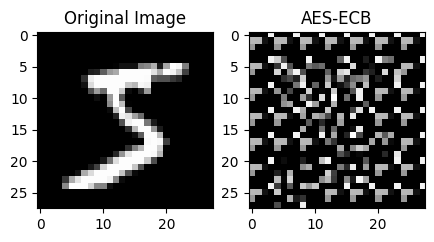

In [59]:
# 显示原始图像和加密的图像
fig, axs = plt.subplots(1, 2, figsize=(5, 5))  
axs[0].imshow(img0, cmap='gray')  
axs[0].set_title('Original Image')  
axs[1].imshow(np.clip(encrypted_images[0], 0, 255).astype(np.uint8), cmap='gray')  
axs[1].set_title('AES-ECB')  
plt.show()

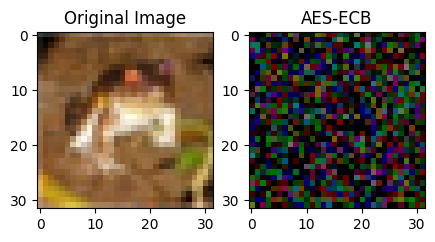

In [60]:
fig, axs = plt.subplots(1, 2, figsize=(5, 5))  
axs[0].imshow(img1)  
axs[0].set_title('Original Image')  
axs[1].imshow(np.clip(encrypted_images[1], 0, 255).astype(np.uint8), cmap='gray')  
axs[1].set_title('AES-ECB')  
plt.show()